In [22]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.integrate import quad
# from utils import generate_yyyymm, validate_uniqueness
import warnings
from scipy.optimize import fmin
from ipywidgets import *
import statsmodels.api as sm
from scipy.integrate import quad
from dateutil.relativedelta import relativedelta
from IPython.display import clear_output

In [466]:
data =시뮬레이션_집계['출재손해액_전체'].copy()

In [469]:
data[data >np.quantile(data, q=0.995)].mean()

1785.2204440729759

In [481]:
# 사용자정의 함수
def summary(data, typ=0):
    if typ==0:
        count = len(data)
        mean = data.mean()
        std = data.std()
        min_ = data.min()
        max_ = data.max()
        q = list(np.quantile(data, q=[0.005, 0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975, 0.995]))
    elif typ==1:
        count = np.nan
        mean = data.mean()
        std = data.std()
        min_ = np.nan
        max_ = np.nan
        q = [data.ppf(0.005), data.ppf(0.025), data.ppf(0.05), data.ppf(0.25), data.ppf(0.50), data.ppf(0.75), data.ppf(0.95), data.ppf(0.975), data.ppf(0.995)]
    return pd.Series(data=[count, mean, std, min_] + q + [data[data>np.quantile(data, q=0.995)].mean()] + [max_], index=['count', 'mean', 'std', 'min', '0.5%', '2.5%', '5%', '25%', '50%', '75%', '95%', '97.5%', '99.5%', 'TVaR(99.5%)', 'max'])

def fit(data):
    dist_names = [
        "alpha","anglit","arcsine","beta","betaprime","bradford","burr","cauchy",
        "chi","chi2","cosine","dgamma","dweibull","erlang","expon","exponweib","exponpow",
        "f","fatiguelife","fisk","foldcauchy","foldnorm","frechet_r","frechet_l",
        "genlogistic","genpareto","genexpon","genextreme","gausshyper","gamma","gengamma",
        "genhalflogistic","gilbrat","gompertz","gumbel_r","gumbel_l","halfcauchy","halflogistic",
        "halfnorm","hypsecant","invgamma","invgauss","invweibull","johnsonsb","johnsonsu",
        "ksone","kstwobign","laplace","logistic","loggamma","loglaplace","lognorm","lomax",
        "maxwell","mielke","nakagami","ncx2","ncf","nct","norm","pareto","pearson3","powerlaw",
        "powerlognorm","powernorm","rdist","reciprocal","rayleigh","rice","recipinvgauss",
        "semicircular","t","triang","truncexpon","truncnorm","tukeylambda","uniform","vonmises",
        "wald","weibull_min","weibull_max","wrapcauchy",
    ]
    
    result = []
    for name in dist_names:
        dist = getattr(scipy.stats, name)
        params = dist.fit(data, floc=0)
        model = dist(*params[:-2], loc=params[-2], scale=params[-1])
        loglik = np.log(model.pdf(data)).sum()
        result.append([name, loglik])

    result = pd.DataFrame(result, columns=['분포명', '로그우도']) \
        .sort_values(by='로그우도', ascending=False) \
        .reset_index(drop=True)
    return result

In [4]:
# 환경설정
pd.set_option('mode.chained_assignment', None)
plt.style.use('default')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
if not any([s == 'result' for s in os.listdir('.')]): os.mkdir('result')
if not any([s == 'img' for s in os.listdir('.')]): os.mkdir('img')
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.0f}'.format
np.random.seed(0)

In [5]:
# 데이터 불러오기
file = pd.ExcelFile('data/Package Insurance Policy_분석결과_20201114211451.xlsx')
실적_가공 = file.parse('실적_가공', dtype={'UY': str})
사고정보_가공 = file.parse('사고정보_가공', dtype={'주관보험사코드': str})

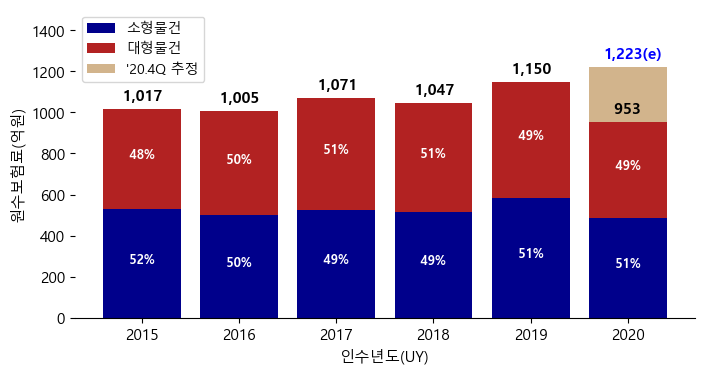

,대형물건,소형물건,합계
UY,,,
2016,4,-6,-1
2017,7,6,7
2018,-3,-2,-2
2019,7,13,10
2020,4,9,6


In [6]:
# 원수보험료
## 원수보험료 집계
원수보험료 = 실적_가공.pivot_table(index='UY', columns='가입금액그룹', values='원수보험료', aggfunc=lambda x: np.sum(x)/1e8) \
    .eval('합계 = 대형물건+소형물건') \
    .eval('비중_대형물건 = 대형물건/합계*100') \
    .eval('비중_소형물건 = 소형물건/합계*100')
원수보험료.columns.name = None

## 원수보험료 '20.4Q 추정
원수보험료3분기 = 실적_가공.loc[lambda x: ~x.UY분기.str.contains("4Q")].pivot_table(index='UY', columns='가입금액그룹', values='원수보험료', aggfunc=lambda x: np.sum(x)/1e8) \
    .eval('합계 = 대형물건+소형물건')
원수보험료3분기.columns.name = None
원수보험료3분기_성장률 = 원수보험료3분기.pct_change()*100
원수보험료3분기_성장률.loc['2020']
원수보험료_성장률 = (원수보험료.pct_change()*100).dropna().drop(['비중_대형물건', '비중_소형물건'], axis=1)
원수보험료_성장률.loc['2020'] = 원수보험료3분기_성장률.loc['2020']
원수보험료19년4Q = 실적_가공.query('UY분기 == "\'19.4Q"').groupby('가입금액그룹')['원수보험료'].sum()/1e8
원수보험료20년4Q = 원수보험료19년4Q*(1+원수보험료_성장률.loc['2020', ['대형물건', '소형물건']]/100)
원수보험료20년4Q['합계'] = 원수보험료20년4Q.sum()

## 원수보험료 시각화
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(x=원수보험료.index, height=원수보험료.소형물건, label='소형물건', color='darkblue')
ax.bar(x=원수보험료.index, bottom=원수보험료.소형물건, height=원수보험료.대형물건, label='대형물건', color='firebrick')
ax.bar(x='2020', bottom=원수보험료.loc['2020', '합계'], height=원수보험료20년4Q['합계'], label='\'20.4Q 추정', color='tan')

plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=11)
ax.set_xlabel('인수년도(UY)', fontsize=11)
ax.set_ylabel('원수보험료(억원)', fontsize=11)
ax.set_ylim([0, 1500])
x, y = -0.175, 40
x2 = -0.25
for i in range(len(원수보험료)):
    ax.text(i+x, 원수보험료.iloc[i]["소형물건"]/2, f'{원수보험료.iloc[i]["비중_소형물건"]:,.0f}%'.center(5), weight='bold', color='white', fontsize=9)
    ax.text(i+x, 원수보험료.iloc[i]["소형물건"]+원수보험료.iloc[i]["대형물건"]/2, f'{원수보험료.iloc[i]["비중_대형물건"]:,.0f}%'.center(5), weight='bold', color='white', fontsize=9)
    ax.text(i+x-0.13, 원수보험료.iloc[i]["합계"]+y, f'{원수보험료.iloc[i]["합계"]:,.0f}'.center(10), weight='bold', fontsize=11)
ax.text(i+x2, 원수보험료.iloc[i]["합계"]+원수보험료20년4Q['합계']+y, f'{원수보험료.iloc[i]["합계"]+원수보험료20년4Q["합계"]:,.0f}(e)'.center(8), weight='bold', color='blue', fontsize=11)
plt.show()

display(원수보험료_성장률)

In [7]:
# 사고접수지연

## 사고접수지연 모델링
사고접수지연_당사_데이터 = 사고정보_가공.query('주관보험사코드 == "13"')['접수지연'] + 0.5
사고접수지연_타사_데이터 = 사고정보_가공.query('주관보험사코드 != "13"')['접수지연'] + 0.5
dist = getattr(scipy.stats, 'johnsonsu')
dist2 = getattr(scipy.stats, 'johnsonsu')
사고접수지연_당사_모수 = dist.fit(사고접수지연_당사_데이터, floc=0)
사고접수지연_타사_모수 = dist2.fit(사고접수지연_타사_데이터, floc=0)
사고접수지연_당사_모형 = dist(*사고접수지연_당사_모수[:-2], loc=사고접수지연_당사_모수[-2], scale=사고접수지연_당사_모수[-1])
사고접수지연_타사_모형 = dist2(*사고접수지연_타사_모수[:-2], loc=사고접수지연_타사_모수[-2], scale=사고접수지연_타사_모수[-1])

## 사고접수지연 시각화
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# 사고접수지연_당사_데이터.plot(kind='hist', bins=500, label='당사단독/당사간사', ax=ax, density=True, alpha=0.75)
# 사고접수지연_타사_데이터.plot(kind='hist', bins=500, label='타사간사', ax=ax, density=True, alpha=0.75)
# x_min, x_max = 0, 접수지연_타사_데이터.max()
# x_range = np.linspace(x_min, x_max, 1000)
# y1_range = 사고접수지연_당사_모델.pdf(x_range)
# y2_range = 사고접수지연_타사_모델.pdf(x_range)
# ax.plot(x_range, y1_range, color='darkslategrey')
# ax.plot(x_range, y2_range, color='darkslategrey')
# ax.fill_between(x_range, 0, y1_range, color='darkslategrey', alpha=0.8, label='모델')
# ax.fill_between(x_range, 0, y2_range, color='darkslategrey', alpha=0.8)

# ax.set_xlabel('접수지연(일)', fontsize=11)
# ax.set_ylabel('밀도', fontsize=11)
# ax.tick_params(rotation=0, labelsize=11)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xlim([0, 500])
# ax.legend()
# plt.tight_layout()
# plt.savefig('img/접수지연')
# plt.show()

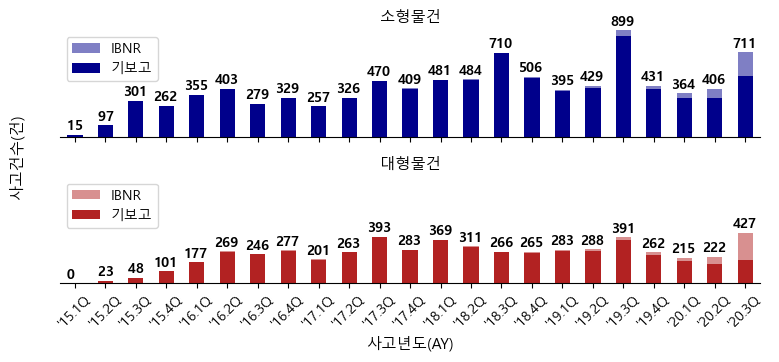

,소형물건,대형물건,합계
사고건수,"8,858","5,173","14,031"
IBNR,462,407,869
보정사고건수,"9,320","5,580","14,900"
원수경과보험료,"2,771","2,738","5,509"
원수손해액,"1,574",899,"2,472"
원수손해율,57,33,45
보정사고건수100억원당,336,204,270
보정원수손해율,60,35,48


In [402]:
# 사고빈도
## 사고건수 보정
사고건수 = 사고정보_가공.assign(당사구분 = lambda x: np.where(x.주관보험사코드 == "13", "당사", "타사")) \
    .pivot_table(index=['AY', 'AY년월', 'AY분기'], columns=['당사구분', '가입금액그룹'], values='사고접수번호', aggfunc=len, fill_value=0) \
    .reset_index()
사고건수['경과월'] = np.arange(len(사고건수))[::-1]+0.5
사고건수['사고건수_보정계수_당사'] = 사고건수['경과월'].apply(lambda i: 30/quad(사고접수지연_당사_모형.cdf, 30*i, 30*(i+1))[0])
사고건수['사고건수_보정계수_타사'] = 사고건수['경과월'].apply(lambda i: 30/quad(사고접수지연_타사_모형.cdf, 30*i, 30*(i+1))[0])
사고건수['사고건수_대형물건'] = 사고건수['당사']['대형물건']+사고건수['타사']['대형물건']
사고건수['사고건수_소형물건'] = 사고건수['당사']['소형물건']+사고건수['타사']['소형물건']
사고건수['보정사고건수_대형물건'] = 사고건수['당사']['대형물건']*사고건수['사고건수_보정계수_당사']+사고건수['타사']['대형물건']*사고건수['사고건수_보정계수_타사']
사고건수['보정사고건수_소형물건'] = 사고건수['당사']['소형물건']*사고건수['사고건수_보정계수_당사']+사고건수['타사']['소형물건']*사고건수['사고건수_보정계수_타사']
사고건수 = 사고건수.drop(['당사', '타사'], axis=1)
사고건수.columns = [x[0] for x in 사고건수.columns]
사고건수 = 사고건수.groupby(['AY', 'AY분기'])[['사고건수_대형물건', '사고건수_소형물건', '보정사고건수_대형물건', '보정사고건수_소형물건']].sum().reset_index()

## 사고건수 시각화
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)

df11 = 사고건수.groupby('AY분기')['보정사고건수_소형물건'].sum()
df12 = 사고건수.groupby('AY분기')['사고건수_소형물건'].sum()
df21 = 사고건수.groupby('AY분기')['보정사고건수_대형물건'].sum()
df22 = 사고건수.groupby('AY분기')['사고건수_대형물건'].sum()
df11.plot(kind='bar', ax=ax[0], label='IBNR', alpha=0.5, color='darkblue')
df12.plot(kind='bar', ax=ax[0], label='기보고', color='darkblue')
df21.plot(kind='bar', ax=ax[1], label='IBNR', alpha=0.5, color='firebrick')
df22.plot(kind='bar', ax=ax[1], label='기보고', color='firebrick')

ax[0].set_ylim([0, 900]); ax[1].set_ylim([0, 900])
ax[1].set_xlabel('사고년도(AY)', fontsize=11)
ax[0].spines['top'].set_visible(False); ax[1].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False); ax[1].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False); ax[1].spines['right'].set_visible(False)
ax[0].legend(loc=2); ax[1].legend(loc=2)
plt.xticks(rotation=45)
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False, right=False, top=False)
plt.ylabel('사고건수(건)', fontsize=11)
ax[0].set_title('소형물건', fontsize=11)
ax[1].set_title('대형물건', fontsize=11)
ax[0].tick_params(labelcolor='black', top=False, bottom=True, left=False, right=False, labelleft=False)
ax[1].tick_params(labelcolor='black', top=False, bottom=True, left=False, right=False, labelleft=False)
x, y = -0.42, 40
for i in range(len(df11)):
    ax[0].text(i+x, df11[i]+y, f'{df11[i]:,.0f}'.center(3), weight='bold')
    ax[1].text(i+x, df21[i]+y, f'{df21[i]:,.0f}'.center(3), weight='bold')
plt.tight_layout()
plt.savefig('img/사고건수')
plt.show()

## 사고건수 집계
사고건수_가공 = 사고건수.melt(id_vars=['AY', 'AY분기'])
사고건수_가공['가입금액그룹'] = 사고건수_가공.variable.str.split('_').str[1]
사고건수_가공['variable'] = 사고건수_가공.variable.str.split('_').str[0]
사고건수_집계 = 사고건수_가공.pivot_table(index='variable', columns='가입금액그룹', values='value', aggfunc=np.sum)
사고건수_집계.loc['IBNR'] = 사고건수_집계.loc['보정사고건수']-사고건수_집계.loc['사고건수']
사고건수_집계.loc['원수경과보험료'] = 실적_가공.groupby('가입금액그룹')['원수경과보험료'].sum()/1e8
사고건수_집계.loc['원수손해액'] = 실적_가공.groupby('가입금액그룹')['원수손해액'].sum()/1e8
사고건수_집계.eval('합계 = 소형물건 + 대형물건', inplace=True)
사고건수_집계.loc['건당손해액'] = 사고건수_집계.loc['원수손해액']/사고건수_집계.loc['사고건수']
사고건수_집계.loc['보정사고건수100억원당'] = 사고건수_집계.loc['보정사고건수']/사고건수_집계.loc['원수경과보험료']*100
사고건수_집계.loc['원수손해율'] = 사고건수_집계.loc['원수손해액']/사고건수_집계.loc['원수경과보험료']*100
사고건수_집계.loc['보정원수손해율'] = 사고건수_집계.loc['건당손해액']*사고건수_집계.loc['보정사고건수']/사고건수_집계.loc['원수경과보험료']*100
사고건수_집계 = 사고건수_집계.loc[['사고건수', 'IBNR', '보정사고건수', '원수경과보험료', '원수손해액', '원수손해율', '보정사고건수100억원당', '보정원수손해율'], ['소형물건', '대형물건', '합계']]
사고건수_집계.index.name = None
사고건수_집계.columns.name = None
사고빈도_소형물건, 사고빈도_대형물건 = 사고건수_집계.loc['보정사고건수100억원당', ['소형물건', '대형물건']]
display(사고건수_집계)

# 사고빈도 모델링
dist = getattr(scipy.stats, 'poisson')
원수보험료21년_대형물건, 원수보험료21년_소형물건 = 600, 600
원수보험료21년 = 원수보험료21년_대형물건+원수보험료21년_소형물건
사고빈도_모형_대형물건 = dist(원수보험료21년_대형물건*사고빈도_대형물건/100)
사고빈도_모형_소형물건 = dist(원수보험료21년_소형물건*사고빈도_소형물건/100)

Optimization terminated successfully.
         Current function value: 28743.119931
         Iterations: 222
         Function evaluations: 364


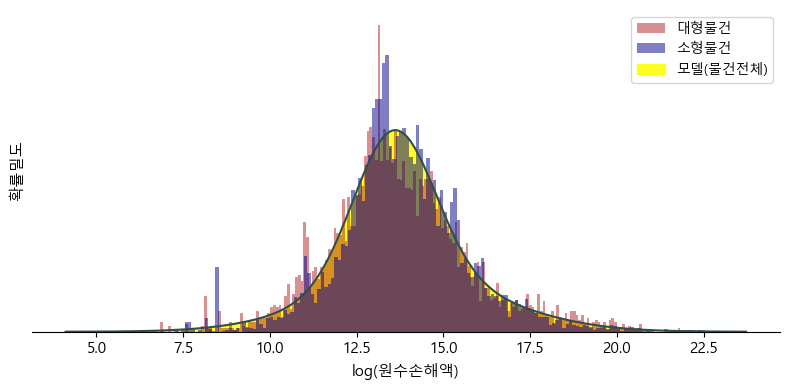

,소형물건,대형물건,전체
count,"8,858","5,173","14,031"
mean,"17,806,383","17,385,043","17,651,042"
std,"289,763,035","154,271,993","248,552,515"
min,61,795,61
0.5%,"3,500","3,500","3,500"
2.5%,"23,824","20,132","22,310"
5%,"57,936","41,867","50,110"
25%,"375,000","274,400","334,400"
50%,"903,986","779,794","855,120"
75%,"2,746,245","2,830,810","2,778,905"


In [11]:
# 사고심도
# 사고심도 통계 요약
손해액_전체_데이터 = 사고정보_가공['원수손해액'].copy()
손해액_대형물건_데이터 = 사고정보_가공.query('가입금액그룹 == "대형물건"')['원수손해액'].copy()
손해액_소형물건_데이터 = 사고정보_가공.query('가입금액그룹 == "소형물건"')['원수손해액'].copy()
손해액_집계 = pd.concat([summary(손해액_소형물건_데이터), summary(손해액_대형물건_데이터), summary(손해액_전체_데이터)], axis=1)
손해액_집계.columns = ['소형물건', '대형물건', '전체']

# 사고심도 모델링(Mixture Distribution)
로그_손해액_전체_데이터 = 사고정보_가공['원수손해액_log'].copy()
로그_손해액_대형물건_데이터 = 사고정보_가공.query('가입금액그룹 == "대형물건"')['원수손해액_log'].copy()
로그_손해액_소형물건_데이터 = 사고정보_가공.query('가입금액그룹 == "소형물건"')['원수손해액_log'].copy()

def obj_fun(args):
    p, mu1, sigma1, mu2, sigma2 = args
    model1 = getattr(scipy.stats, 'norm')(mu1, sigma1)
    model2 = getattr(scipy.stats, 'norm')(mu2, sigma2)
    loglik = np.log(p*model1.pdf(로그_손해액_전체_데이터)+(1-p)*model2.pdf(로그_손해액_전체_데이터)).sum()
    return -loglik

x0 = (0.5, 13, 1.5, 14, 2.5)
가중치, mu1, sigma1, mu2, sigma2 = scipy.optimize.fmin(obj_fun, x0)
dist = getattr(scipy.stats, 'norm')
사고심도_모형1 = dist(mu1, sigma1)
사고심도_모형2 = dist(mu2, sigma2)

# 사고심도 시각화
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

로그_손해액_대형물건_데이터.plot(kind='hist', density=True, bins=200, color='firebrick', alpha=0.5, label='대형물건', ax=ax)
로그_손해액_소형물건_데이터.plot(kind='hist', density=True, bins=200, color='darkblue', alpha=0.5, label='소형물건', ax=ax)
x_min, x_max = 로그_손해액_전체_데이터.min(), 로그_손해액_전체_데이터.max()
x_range = np.linspace(x_min, x_max, 1000)
y_range = 가중치*사고심도_모형1.pdf(x_range)+(1-가중치)*사고심도_모형2.pdf(x_range)
ax.plot(x_range, y_range, color='darkslategrey')
ax.fill_between(x_range, 0, y_range, color='yellow', alpha=0.85, label='모델(물건전체)')
ax.set_xlabel('log(원수손해액)', fontsize=11)
ax.set_ylabel('확률밀도', fontsize=11)
ax.tick_params(rotation=0, labelsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelcolor='black', top=False, bottom=True, left=False, right=False, labelleft=False)
ax.legend()

plt.tight_layout()
plt.savefig('img/원수손해액분포')
plt.show()

display(손해액_집계)

In [ ]:
# # 사고심도 시뮬레이션
# 사고심도_시뮬레이션횟수_전체 = 100000
# 사고심도_시뮬레이션횟수_모형1 = sum(np.random.random(size=사고심도_시뮬레이션횟수_전체) < 가중치)
# 사고심도_시뮬레이션횟수_모형2 = 사고심도_시뮬레이션횟수_전체-사고심도_시뮬레이션횟수_모형1
# 사고심도_시뮬레이션결과 = np.exp(np.r_[사고심도_모형1.rvs(사고심도_시뮬레이션횟수_모형1), 사고심도_모형2.rvs(사고심도_시뮬레이션횟수_모형2)])

In [91]:
# 시뮬레이션
시뮬레이션횟수 = 50000

## 사고건수
사고건수_시뮬레이션 = pd.DataFrame(np.c_[사고빈도_모형_소형물건.rvs(시뮬레이션횟수), 사고빈도_모형_대형물건.rvs(시뮬레이션횟수)], columns=['사고건수_소형물건', '사고건수_대형물건']) \
    .eval('사고건수_전체 = 사고건수_소형물건 + 사고건수_대형물건')

## 원수손해액
원수손해액_시뮬레이션 = []
for i, (사고건수_난수_소형물건, 사고건수_난수_대형물건, 사고건수_난수_전체) in 사고건수_시뮬레이션.iterrows():
    사고심도_시뮬레이션횟수_모형1 = sum(np.random.random(사고건수_난수_전체) < 가중치)
    사고심도_시뮬레이션횟수_모형2 = 사고건수_난수_전체 - 사고심도_시뮬레이션횟수_모형1
    사고심도_시뮬레이션결과 = np.exp(np.random.permutation(np.r_[사고심도_모형1.rvs(사고심도_시뮬레이션횟수_모형1), 사고심도_모형2.rvs(사고심도_시뮬레이션횟수_모형2)]))
    원수손해액_난수_소형물건, 원수손해액_난수_대형물건 = 사고심도_시뮬레이션결과[:사고건수_난수_소형물건].sum(), 사고심도_시뮬레이션결과[사고건수_난수_소형물건:].sum()
    원수손해액_시뮬레이션.append([원수손해액_난수_소형물건, 원수손해액_난수_대형물건])
    if i%100 == 0:
        clear_output(wait=True)
        print(f'진행률 : {i/len(사고건수_시뮬레이션)*100:,.2f}%')
clear_output(wait=True)
print(f'진행완료')
원수손해액_시뮬레이션 = pd.DataFrame(원수손해액_시뮬레이션, columns=['원수손해액_소형물건', '원수손해액_대형물건']) \
    .eval('원수손해액_전체 = 원수손해액_소형물건 + 원수손해액_대형물건')
원수손해액_시뮬레이션 /= 1e8

## 집계
시뮬레이션_집계 = pd.concat([사고건수_시뮬레이션, 원수손해액_시뮬레이션], axis=1) \
    .eval('원수보험료_전체 = @원수보험료21년_대형물건+@원수보험료21년_소형물건') \
    .eval('원수손해율_소형물건 = 원수손해액_소형물건/@원수보험료21년_소형물건*100') \
    .eval('원수손해율_대형물건 = 원수손해액_대형물건/@원수보험료21년_대형물건*100') \
    .eval('원수손해율_전체 = 원수손해액_전체/원수보험료_전체*100')

진행완료


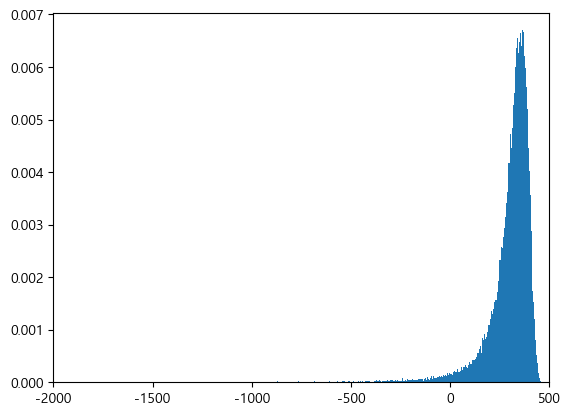

In [512]:
출재율_소형물건, 출재율_대형물건 = 0.4, 0.6
# 손해율스프레드_소형물건, 손해율스프레드_대형물건 = 0.1, 0.1
손해율스프레드_소형물건, 손해율스프레드_대형물건 = 0.100, 0.065
출재수수료율_소형물건, 출재수수료율_대형물건 = 0.14, 0.10
출재보험료21년_소형물건, 출재보험료21년_대형물건 = 원수보험료21년_소형물건*출재율_소형물건, 원수보험료21년_대형물건*출재율_대형물건
시뮬레이션_집계 = 시뮬레이션_집계 \
    .eval('출재보험료_전체 = @원수보험료21년_소형물건*@출재율_소형물건+@원수보험료21년_대형물건*@출재율_대형물건') \
    .eval('출재손해액_소형물건 = 원수손해액_소형물건*@출재율_소형물건-@출재보험료21년_소형물건*@손해율스프레드_소형물건') \
    .eval('출재손해액_대형물건 = 원수손해액_대형물건*@출재율_대형물건-@출재보험료21년_대형물건*@손해율스프레드_대형물건') \
    .eval('출재손해액_전체 = 출재손해액_소형물건+출재손해액_대형물건') \
    .eval('출재손해율_소형물건 = 출재손해액_소형물건/@출재보험료21년_소형물건*100') \
    .eval('출재손해율_대형물건 = 출재손해액_대형물건/@출재보험료21년_대형물건*100') \
    .eval('출재손해율_전체 = 출재손해액_전체/출재보험료_전체*100') \
    .eval('출재합산비율_소형물건 = 출재손해율_소형물건+@출재수수료율_소형물건*100') \
    .eval('출재합산비율_대형물건 = 출재손해율_대형물건+@출재수수료율_대형물건*100') \
    .eval('출재합산비율_전체 = 출재손해율_전체+(@출재보험료21년_소형물건*@출재수수료율_소형물건+@출재보험료21년_대형물건*@출재수수료율_대형물건)/(@출재보험료21년_소형물건+@출재보험료21년_대형물건)*100') \
    .eval('출재수지손_소형물건 = @출재보험료21년_소형물건*(1-출재합산비율_소형물건/100)') \
    .eval('출재수지손_대형물건 = @출재보험료21년_대형물건*(1-출재합산비율_대형물건/100)') \
    .eval('출재수지손_전체 = 출재보험료_전체*(1-출재합산비율_전체/100)')
summary(-시뮬레이션_집계['출재수지손_전체'])
plt.hist(시뮬레이션_집계['출재수지손_전체'], bins=2000, density=True);
plt.xlim([-2000, 500])
plt.show()

In [501]:
x = 시뮬레이션_집계['출재수지손_전체']
len(x[x<0])/len(x)

0.03032

In [425]:
시뮬레이션_집계['원수손해율_소형물건'].mean(), 시뮬레이션_집계['원수손해율_대형물건'].mean()

(62.21930518382233, 37.427315350475965)

In [426]:
시뮬레이션_집계['출재손해율_소형물건'].mean(), 시뮬레이션_집계['출재손해율_대형물건'].mean()

(52.21930518382207, 30.927315350475777)

In [427]:
시뮬레이션_집계['출재합산비율_소형물건'].mean(), 시뮬레이션_집계['출재합산비율_대형물건'].mean()

(66.21930518382213, 40.92731535047605)

In [428]:
시뮬레이션_집계['출재수지손_소형물건'].mean(), 시뮬레이션_집계['출재수지손_대형물건'].mean()

(81.07366755882616, 212.66166473828682)

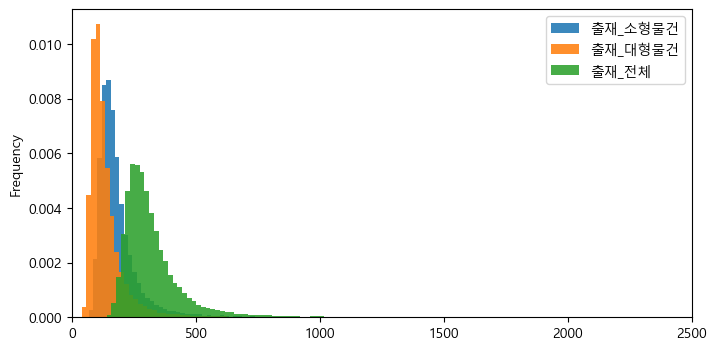

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# 시뮬레이션_집계['원수손해액_소형물건'].plot(kind='hist', density=True, bins=500, alpha=0.875, label='원수_소형물건')
# 시뮬레이션_집계['원수손해액_대형물건'].plot(kind='hist', density=True, bins=500, alpha=0.875, label='원수_대형물건')
# 시뮬레이션_집계['원수손해액_전체'].plot(kind='hist', density=True, bins=500, alpha=0.875, label='원수_전체')
시뮬레이션_집계['출재손해액_소형물건'].plot(kind='hist', density=True, bins=500, alpha=0.875, label='출재_소형물건')
시뮬레이션_집계['출재손해액_대형물건'].plot(kind='hist', density=True, bins=500, alpha=0.875, label='출재_대형물건')
시뮬레이션_집계['출재손해액_전체'].plot(kind='hist', density=True, bins=500, alpha=0.875, label='출재_전체')

plt.legend()
plt.xlim([0, 2500])
plt.show()

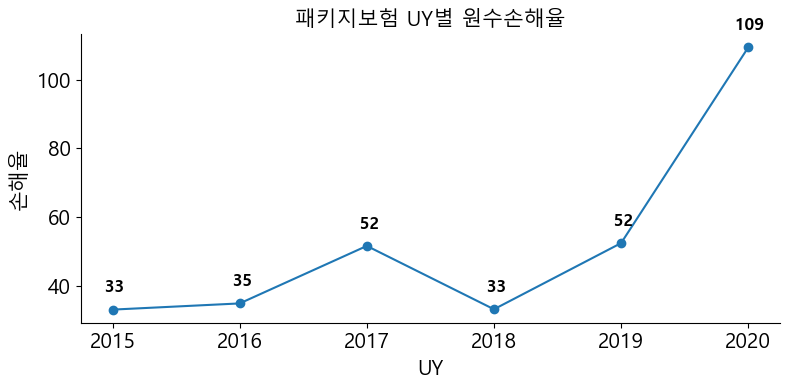

In [610]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

df = 실적_가공.groupby('UY')[['원수경과보험료', '원수손해액']].sum().eval('원수손해율 = 원수손해액/원수경과보험료*100')['원수손해율']
df.plot(kind='line', marker='o', ax=ax)
ax.set_title('패키지보험 UY별 원수손해율', fontsize=15)
ax.set_xlabel('UY', fontsize=15)
ax.set_ylabel('손해율', fontsize=15)
ax.tick_params(rotation=0, labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(len(df)):
    ax.text(i-0.15, df[i]+5, f'{df[i]:,.0f}'.center(5), size=12, weight='bold')

plt.tight_layout()
plt.savefig('img/UY별손해율')
plt.show()

In [100]:
대형물건_요약 = summary(사고정보_가공.query('가입금액그룹 == "대형물건"')['원수손해액'])
소형물건_요약 = summary(사고정보_가공.query('가입금액그룹 == "소형물건"')['원수손해액'])
전체_요약 = summary(사고정보_가공['원수손해액'])
요약 = pd.concat([대형물건_요약, 소형물건_요약, 전체_요약], axis=1) \
    .rename(columns={0: '대형물건', 1: '소형물건', 2: '전체'})
요약

,대형물건,소형물건,전체
count,"5,173","8,858","14,031"
mean,"17,385,043","17,806,383","17,651,042"
std,"154,271,993","289,763,035","248,552,515"
min,795,61,61
0.5%,"3,500","3,500","3,500"
2.5%,"20,132","23,824","22,310"
5%,"41,867","57,936","50,110"
25%,"274,400","375,000","334,400"
50%,"779,794","903,986","855,120"
75%,"2,830,810","2,746,245","2,778,905"


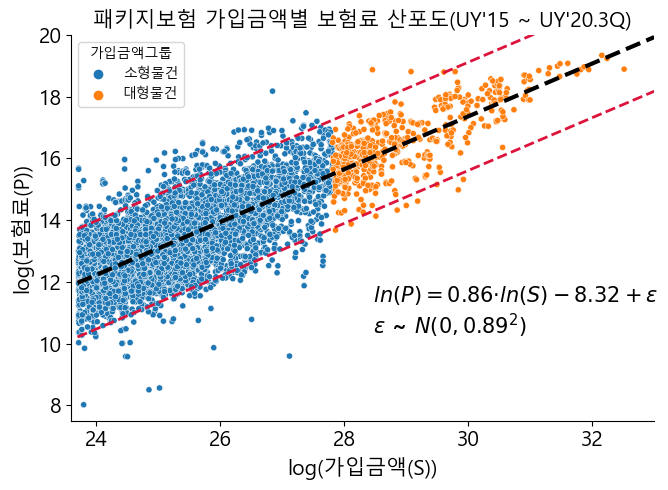

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# df = 실적_가공.groupby(['증권번호', 'UY', '당사보험가입금액'])['원수보험료'].sum().reset_index() \
#     .groupby('UY')[['원수보험료', '당사보험가입금액']].sum() \
#     .eval('요율 = 원수보험료/당사보험가입금액*100')
# df['요율'].plot(kind='line', marker='o', ax=ax[0], color='orangered')
# ax[0].set_title('패키지보험 UY별 요율', fontsize=15)
# ax[0].set_xlabel('UY', fontsize=15)
# ax[0].set_ylabel('요율(%)', fontsize=15)
# ax[0].tick_params(rotation=0, labelsize=15)
# ax[0].spines['top'].set_visible(False)
# ax[0].spines['right'].set_visible(False)
# for x in range(len(df)):
#     ax[0].text(x-0.2, df['요율'][x], f'{df["요율"][x]:,.3f}', color='white', fontsize=12, fontweight='bold', bbox={'pad': 0.3, 'color': 'orangered', 'boxstyle': 'circle'})

df = 실적_가공.query('총보험가입금액 > 2e10').groupby(['증권번호', 'UY', '공동인수율', '당사보험가입금액', '총보험가입금액', '가입금액그룹']) \
    [['원수보험료', '원수경과보험료', '원수손해액', '임의출재보험료', '임의출재경과보험료', '임의출재손해액', '임의출재수수료']].sum().reset_index() \
        .eval('조정원수보험료 = 원수보험료/공동인수율') \
        .eval('요율 = 원수보험료/당사보험가입금액*100') \
        .assign(총보험가입금액_log = lambda x: np.log(x.총보험가입금액)) \
        .assign(조정원수보험료_log = lambda x: np.log(x.조정원수보험료))
sns.scatterplot(x='총보험가입금액_log', y='조정원수보험료_log', hue='가입금액그룹', data=df, s=20, ax=ax)
X_train = sm.add_constant(df['총보험가입금액_log'])
y_train = df['조정원수보험료_log']
model = sm.OLS(y_train, X_train)
res = model.fit()
const, beta = res.params
sigma = res.mse_resid
X_pred = np.linspace(23.7, 33, 100)
y_pred = res.predict(sm.add_constant(np.linspace(23.7, 33, 100)))
plt.plot(X_pred, y_pred, color='black', alpha=1, linestyle='dashed', lw=3)
plt.plot(X_pred, y_pred+1.96*sigma, color='crimson', alpha=1, linestyle='dashed', lw=2)
plt.plot(X_pred, y_pred-1.96*sigma, color='crimson', alpha=1, linestyle='dashed', lw=2)
ax.set_title('패키지보험 가입금액별 보험료 산포도(UY\'15 ~ UY\'20.3Q)', fontsize=15)
ax.set_xlabel('log(가입금액(S))', fontsize=15)
ax.set_ylabel('log(보험료(P))', fontsize=15)
ax.tick_params(rotation=0, labelsize=15)
ax.set_xlim([23.6, 33])
ax.set_ylim([7.5, 20])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(28, 9.5, f"""
    $ln(P) = {beta:.2f}·ln(S) - {-const:.2f} + ε$\n\
    $\epsilon$ ~ $N(0, {sigma:,.2f}^2)$
""", size=15, weight='bold')
    
plt.tight_layout()
plt.savefig('img/요율')
plt.show()

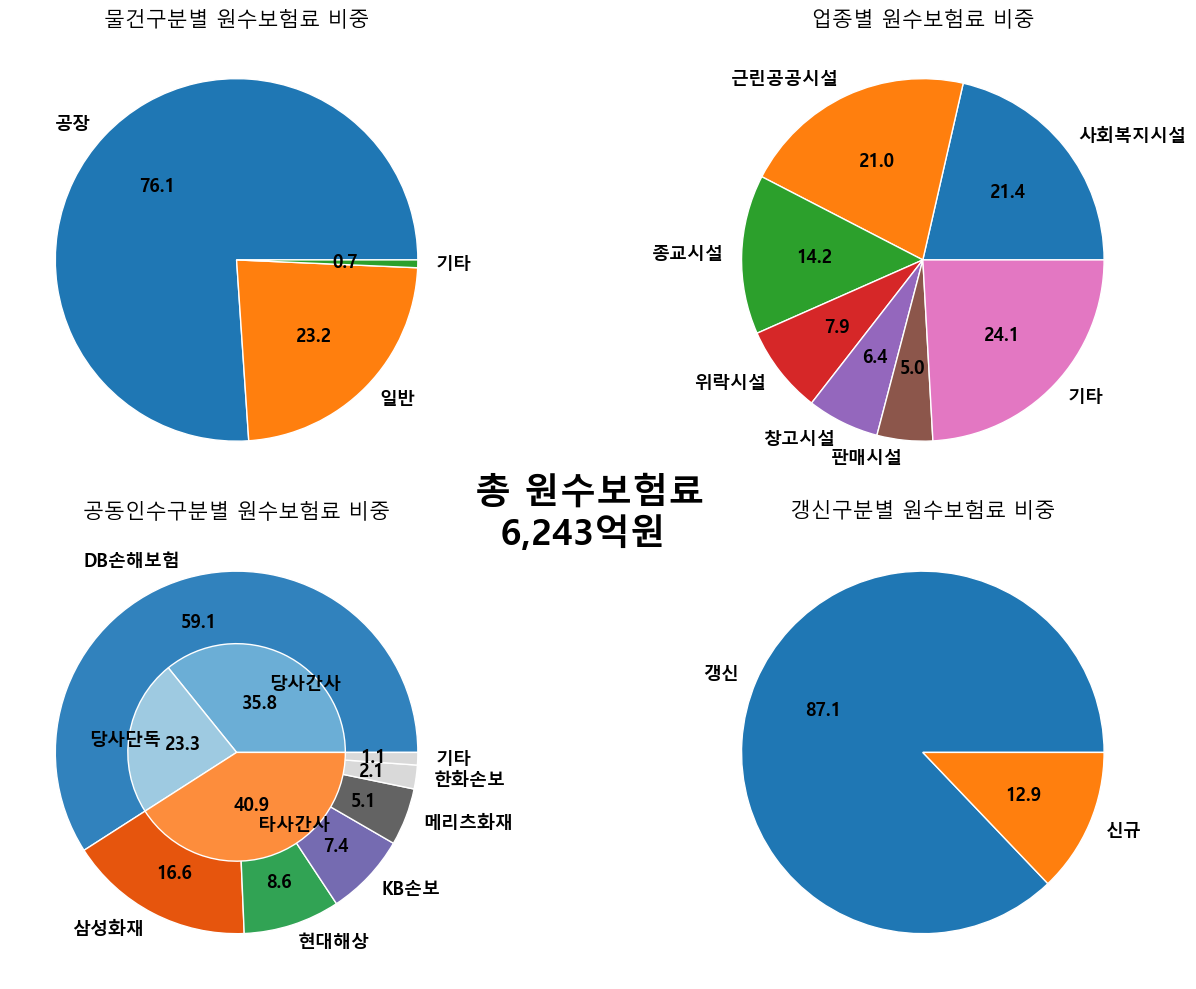

In [106]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(7)*4)
inner_colors = cmap(np.array([1, 2, 5]))

지표 = '원수보험료'

df = 실적_가공.groupby('물건구분명')[[지표]].sum().sort_values(by=지표, ascending=False).reset_index()
물건순서 = df.iloc[:2, 0].tolist() + ['기타']
물건기타 = df.iloc[2:].index
df.loc[lambda x: x.index.isin(물건기타), '물건구분명'] = '기타'
df = df.groupby('물건구분명')[지표].sum()[물건순서]
df.plot(kind='pie', y='원수보험료', ax=ax[0][0], legend=None, radius=1,
        wedgeprops={'width': 1, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.6, counterclock=True, labeldistance=1.1)
ax[0][0].set_ylabel(None)
ax[0][0].set_title(f'물건구분별 {지표} 비중', fontsize=15)

df = 실적_가공.groupby('화재업종대분류명')[[지표]].sum().sort_values(by=지표, ascending=False).reset_index()
화재업종순서 = df.iloc[:6, 0].tolist() + ['기타']
화재업종기타 = df.iloc[6:].index
df.loc[lambda x: x.index.isin(화재업종기타), '화재업종대분류명'] = '기타'
df = df.groupby('화재업종대분류명')[지표].sum()[화재업종순서]
df.plot(kind='pie', y=지표, ax=ax[0][1], legend=None, radius=1,
        wedgeprops={'width': 1, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.6, counterclock=True, labeldistance=1.1)
ax[0][1].set_ylabel(None)
ax[0][1].set_title(f'업종별 {지표} 비중', fontsize=15)


df = 실적_가공.groupby('보험사명')[[지표]].sum().sort_values(by=지표, ascending=False).reset_index()
보험사명순서 = df.iloc[:6, 0].tolist() + ['기타']
보험사명기타 = df.iloc[6:, 0].tolist()
df = 실적_가공.assign(보험사명 = lambda x: np.where(x.보험사명.isin(보험사명기타), "기타", x.보험사명)) \
    .groupby('보험사명')[지표].sum()[보험사명순서]
df.plot(kind='pie', y=지표, ax=ax[1][0], legend=None, radius=1, colors=outer_colors,
        wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.75, counterclock=True, labeldistance=1.1)
df2 = 실적_가공 \
    .groupby('공동인수구분명')[지표].sum()[['당사간사', '당사단독', '타사간사']]
df2.plot(kind='pie', y=지표, ax=ax[1][0], legend=None, radius=1.2-0.6, colors=inner_colors,
          wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold'}, startangle=0, pctdistance=0.5, counterclock=True, labeldistance=.7)
ax[1][0].set_ylabel(None)
ax[1][0].set_title(f'공동인수구분별 {지표} 비중', fontsize=15)

df = 실적_가공.groupby('갱신구분명')[지표].sum()
df.plot(kind='pie', y=지표, ax=ax[1][1], legend=None, radius=1,
        wedgeprops={'width': 1, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.6, counterclock=True, labeldistance=1.1)
ax[1][1].set_ylabel(None)
ax[1][1].set_title(f'갱신구분별 {지표} 비중', fontsize=15)

fig.text(0.43, 0.45, f'총 원수보험료\n  {df.sum()/1e8:,.0f}억원', size=26, weight='bold')

plt.tight_layout()
plt.savefig(f'img/구분별 {지표} 비중')
plt.show()

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# cmap = plt.get_cmap("tab20c")
# outer_colors = cmap(np.arange(7)*4)
# inner_colors = cmap(np.array([1, 2, 5]))

# 지표 = '원수손해액'
# 물건구분 = '소형물건'

# df = 실적_가공.query('가입금액그룹 == @물건구분').groupby('물건구분명')[[지표]].sum().sort_values(by=지표, ascending=False).reset_index()
# 물건순서 = df.iloc[:2, 0].tolist() + ['기타']
# 물건기타 = df.iloc[2:].index
# df.loc[lambda x: x.index.isin(물건기타), '물건구분명'] = '기타'
# df = df.groupby('물건구분명')[지표].sum()[물건순서]
# df.plot(kind='pie', y='원수보험료', ax=ax[0][0], legend=None, radius=1,
#         wedgeprops={'width': 1, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
#           textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.6, counterclock=True, labeldistance=1.1)
# ax[0][0].set_ylabel(None)
# ax[0][0].set_title(f'물건구분별 {지표} 비중', fontsize=15)

# df = 실적_가공.query('가입금액그룹 == @물건구분').groupby('화재업종대분류명')[[지표]].sum().sort_values(by=지표, ascending=False).reset_index()
# 화재업종순서 = df.iloc[:6, 0].tolist() + ['기타']
# 화재업종기타 = df.iloc[6:].index
# df.loc[lambda x: x.index.isin(화재업종기타), '화재업종대분류명'] = '기타'
# df = df.groupby('화재업종대분류명')[지표].sum()[화재업종순서]
# df.plot(kind='pie', y=지표, ax=ax[0][1], legend=None, radius=1,
#         wedgeprops={'width': 1, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
#           textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.6, counterclock=True, labeldistance=1.1)
# ax[0][1].set_ylabel(None)
# ax[0][1].set_title(f'업종별 {지표} 비중', fontsize=15)


# df = 실적_가공.query('가입금액그룹 == @물건구분').groupby('보험사명')[[지표]].sum().sort_values(by=지표, ascending=False).reset_index()
# 보험사명순서 = df.iloc[:6, 0].tolist() + ['기타']
# 보험사명기타 = df.iloc[6:, 0].tolist()
# df = 실적_가공.query('가입금액그룹 == @물건구분').assign(보험사명 = lambda x: np.where(x.보험사명.isin(보험사명기타), "기타", x.보험사명)) \
#     .groupby('보험사명')[지표].sum()[보험사명순서]
# df.plot(kind='pie', y=지표, ax=ax[1][0], legend=None, radius=1, colors=outer_colors,
#         wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
#           textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.75, counterclock=True, labeldistance=1.1)
# df2 = 실적_가공.query('가입금액그룹 == @물건구분') \
#     .groupby('공동인수구분명')[지표].sum()[['당사간사', '당사단독', '타사간사']]
# df2.plot(kind='pie', y=지표, ax=ax[1][0], legend=None, radius=1.2-0.6, colors=inner_colors,
#           wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
#           textprops={'size': 13, 'weight': 'bold'}, startangle=0, pctdistance=0.5, counterclock=True, labeldistance=.7)
# ax[1][0].set_ylabel(None)
# ax[1][0].set_title(f'공동인수구분별 {지표} 비중', fontsize=15)

# df = 실적_가공.query('가입금액그룹 == @물건구분').groupby('갱신구분명')[지표].sum()
# df.plot(kind='pie', y=지표, ax=ax[1][1], legend=None, radius=1,
#         wedgeprops={'width': 1, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
#           textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.6, counterclock=True, labeldistance=1.1)
# ax[1][1].set_ylabel(None)
# ax[1][1].set_title(f'갱신구분별 {지표} 비중', fontsize=15)

# fig.text(0.43, 0.45, f'총 원수보험료\n  {df.sum()/1e8:,.0f}억원', size=26, weight='bold')

# plt.tight_layout()
# plt.savefig(f'img/({물건구분})구분별 {지표} 비중')
# plt.show()

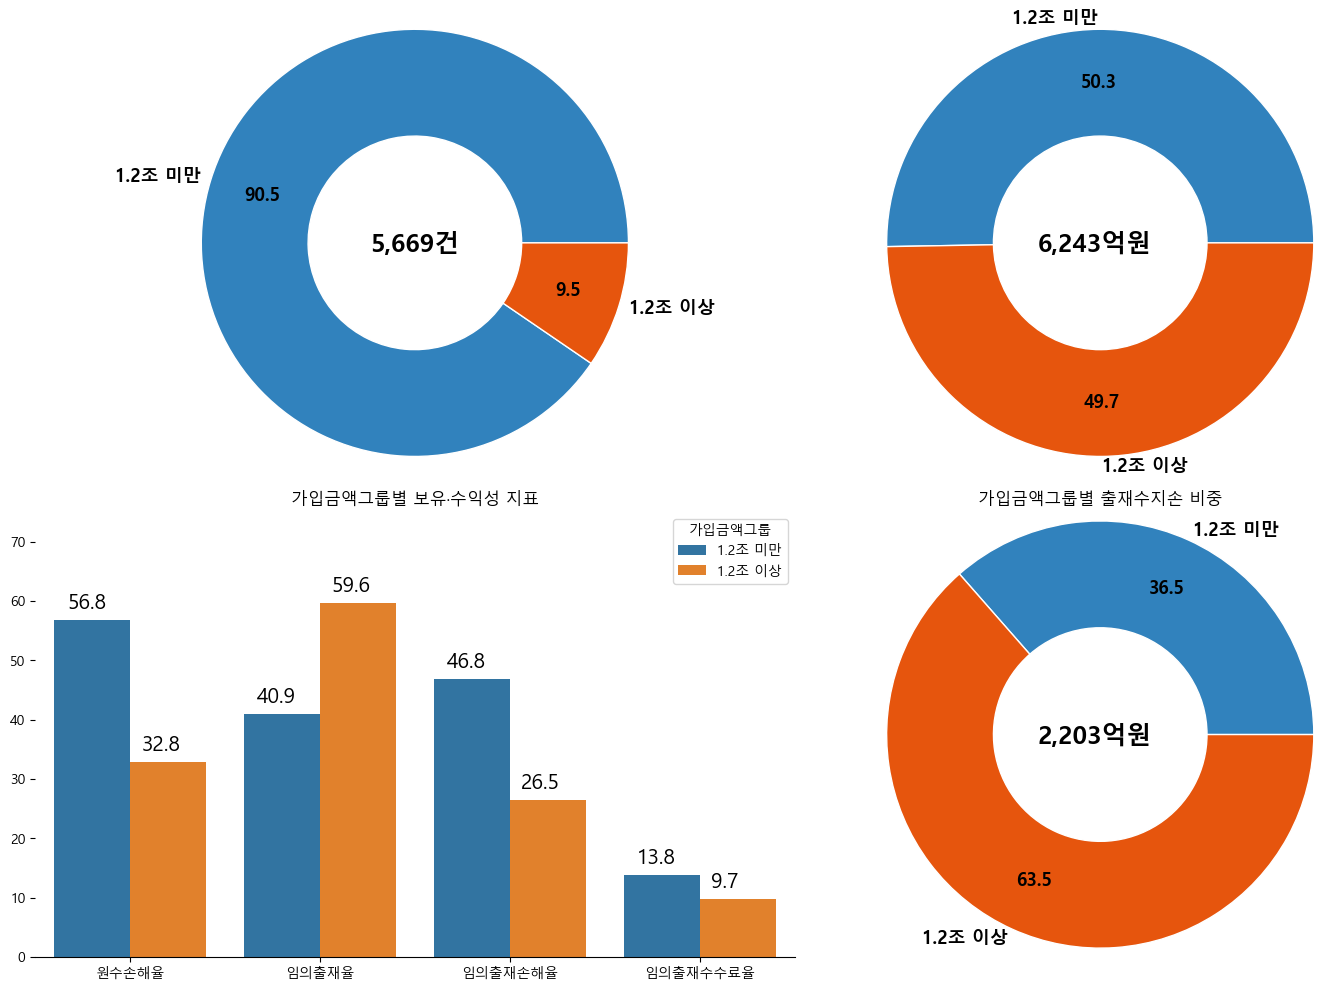

In [409]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

지표전체 = [
    '원수보험료', '원수경과보험료','원수손해액',
    '출재보험료', '출재경과보험료', '출재손해액', '출재수수료',
    '특약출재보험료', '특약출재경과보험료', '특약출재손해액', '특약출재수수료',
    '임의출재보험료', '임의출재경과보험료', '임의출재손해액', '임의출재수수료'
]

df = 실적_가공 \
    .assign(가입금액그룹 = lambda x: np.where(x.총보험가입금액 < 1.2e12, '1.2조 미만', '1.2조 이상')) \
    .groupby(['증권번호', '가입금액그룹'])[지표전체].sum().reset_index()
건수 = df.groupby('가입금액그룹').size()
df = df.groupby('가입금액그룹')[지표전체].sum()
df['건수'] = 건수
df = df.eval('출재수지손 = 출재경과보험료 - 출재손해액 + 출재수수료') \
    .eval('특약출재수지손 = 특약출재경과보험료 - 특약출재손해액 + 특약출재수수료') \
    .eval('임의출재수지손 = 임의출재경과보험료 - 임의출재손해액 + 임의출재수수료') \
    .eval('출재율 = 출재보험료/원수보험료*100') \
    .eval('특약출재율 = 특약출재보험료/원수보험료*100') \
    .eval('임의출재율 = 임의출재보험료/원수보험료*100') \
    .eval('원수손해율 = 원수손해액/원수경과보험료*100') \
    .eval('출재손해율 = 출재손해액/출재경과보험료*100') \
    .eval('특약출재손해율 = 특약출재손해액/특약출재경과보험료*100') \
    .eval('임의출재손해율 = 임의출재손해액/임의출재경과보험료*100') \
    .eval('출재수수료율 = 출재수수료/출재보험료*100') \
    .eval('특약출재수수료율 = 특약출재수수료/특약출재보험료*100') \
    .eval('임의출재수수료율 = 임의출재수수료/임의출재보험료*100')
지표목록 = ['원수손해율', '임의출재율', '임의출재손해율', '임의출재수수료율']
df['건수'].plot(kind='pie', ax=ax[0][0], legend=None, radius=1.2, colors=outer_colors,
        wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.75, counterclock=True, labeldistance=1.05)
ax[0][0].set_ylabel('')
ax[0][0].text(-0.25, -0.05, f"{df['건수'].sum():,.0f}건", size=18, weight='bold')
df['원수보험료'].plot(kind='pie', ax=ax[0][1], legend=None, radius=1.2, colors=outer_colors,
        wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.75, counterclock=True, labeldistance=1.05)
ax[0][1].set_ylabel('')
ax[0][1].text(-0.35, -0.05, f"{df['원수보험료'].sum()/1e8:,.0f}억원", size=18, weight='bold')

df2 = df[지표목록].reset_index().melt(id_vars='가입금액그룹')
sns.barplot(x='variable', y='value', data=df2, hue='가입금액그룹', ax=ax[1][0])
ax[1][0].set_ylabel('')
ax[1][0].set_xlabel('')
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
for i in range(4):
    ax[1][0].text(i-0.33, df[지표목록[i]]['1.2조 미만']+2, f'{df[지표목록[i]]["1.2조 미만"]:,.1f}', size=15)
    ax[1][0].text(i+0.06, df[지표목록[i]]['1.2조 이상']+2, f'{df[지표목록[i]]["1.2조 이상"]:,.1f}', size=15)
ax[1][0].set_title('가입금액그룹별 보유·수익성 지표')
ax[1][0].set_ylim([0, 75])
    
df.plot(kind='pie', ax=ax[1][1], y='임의출재수지손', legend=None, radius=1.2, colors=outer_colors,
        wedgeprops={'width': .6, 'edgecolor': 'w'}, autopct=lambda pct: f'{pct:,.1f}',
          textprops={'size': 13, 'weight': 'bold', 'color': 'black'}, startangle=0, pctdistance=0.75, counterclock=True, labeldistance=1.05)
ax[1][1].text(-0.35, -0.05, f"{df['임의출재수지손'].sum()/1e8:,.0f}억원", size=18, weight='bold')
ax[1][1].set_ylabel('')
ax[1][1].set_title('가입금액그룹별 출재수지손 비중')

# plt.subplots_adjust(wspace=2, hspace=1)
plt.tight_layout()
plt.savefig('img/가입금액별')
plt.show()

In [110]:
지표전체 = [
    '원수보험료', '원수경과보험료','원수손해액',
    '출재보험료', '출재경과보험료', '출재손해액', '출재수수료',
    '특약출재보험료', '특약출재경과보험료', '특약출재손해액', '특약출재수수료',
    '임의출재보험료', '임의출재경과보험료', '임의출재손해액', '임의출재수수료'
]

df = 실적_가공 \
    .groupby(['증권번호'])[지표전체].sum().reset_index()
건수 = df.shape[0]
df = df[지표전체].sum()
df['건수'] = 건수

df = df.to_frame().T.eval('출재수지손 = 출재경과보험료 - 출재손해액 + 출재수수료') \
    .eval('특약출재수지손 = 특약출재경과보험료 - 특약출재손해액 + 특약출재수수료') \
    .eval('임의출재수지손 = 임의출재경과보험료 - 임의출재손해액 + 임의출재수수료') \
    .eval('출재율 = 출재보험료/원수보험료*100') \
    .eval('특약출재율 = 특약출재보험료/원수보험료*100') \
    .eval('임의출재율 = 임의출재보험료/원수보험료*100') \
    .eval('원수손해율 = 원수손해액/원수경과보험료*100') \
    .eval('출재손해율 = 출재손해액/출재경과보험료*100') \
    .eval('특약출재손해율 = 특약출재손해액/특약출재경과보험료*100') \
    .eval('임의출재손해율 = 임의출재손해액/임의출재경과보험료*100') \
    .eval('출재수수료율 = 출재수수료/출재보험료*100') \
    .eval('특약출재수수료율 = 특약출재수수료/특약출재보험료*100') \
    .eval('임의출재수수료율 = 임의출재수수료/임의출재보험료*100') \
    .T[0]

In [214]:
# 출력
now = datetime.now().strftime('%Y%m%d%H%M%S')
with pd.ExcelWriter(f'result/패키지보험_분석결과_{now}.xlsx', 'xlsxwriter') as writer:
#     실적_가공.to_excel(writer, '실적_가공', index=False)
#     사고정보_가공.to_excel(writer, '사고정보_가공', index=False)
    사고건수.to_excel(writer, '사고건수', index=False)